In [6]:
pip install scikit-learn

  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from Compute_Jacobian import jacobian
import timeit

#from models_tf import Sampler, NN_FF

from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:




class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name = None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name
    def sample(self, N):
        x = self.coords[0:1,:] + (self.coords[1:2,:]-self.coords[0:1,:])*np.random.rand(N, self.dim)
        y = self.func(x)
        return x, y


class heat1D_ST_FF:
    def __init__(self, layers, operator, k, ics_sampler, bcs_sampler, res_sampler,  sigma_wt, sigma_wx, X_star, u_star):
        X, _ = res_sampler.sample(np.int32(1e5))
        self.mu_X, self.sigma_X = X.mean(0), X.std(0)
        self.mu_t, self.sigma_t = self.mu_X[0], self.sigma_X[0]
        self.mu_x, self.sigma_x = self.mu_X[1], self.sigma_X[1]
        
        # Samplers
        self.ics_sampler = ics_sampler
        self.bcs_sampler = bcs_sampler
        self.res_sampler = res_sampler
        
        # Define differential operator
        self.k = k
        self.operator = operator
        
        # Fourier hyperparameter
        self.sigma_wt = sigma_wt
        self.sigma_wx = sigma_wx

        # Initialize spatial and temporal Fourier features
        self.W_t =tf.Variable(tf.random_normal([1, layers[0] //2], dtype=tf.float32)  * sigma_wt, dtype=tf.float32, trainable=False)
        self.W_x = tf.Variable(tf.random_normal([1, layers[0] //2], dtype=tf.float32)  * sigma_wx, dtype=tf.float32, trainable=False)
        
        # Initialize network weights and biases
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)

        # Define Tensorflow session
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

        # Define placeholders and computational graph
        self.t_u_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_u_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_ics_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_ics_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_ics_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))

#         self.t_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
#         self.x_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
#         self.u_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        
        # Evaluate predictions
        self.u_ics_pred = self.net_u(self.t_ics_tf, self.x_ics_tf)
        self.u_bc1_pred = self.net_u(self.t_bc1_tf, self.x_bc1_tf)
#         self.u_bc2_pred = self.net_u(self.t_bc2_tf, self.x_bc2_tf)
        
        self.u_pred = self.net_u(self.t_u_tf, self.x_u_tf)
        self.r_pred = self.net_r(self.t_r_tf, self.x_r_tf)

        # Boundary loss and Initial loss
        self.loss_ic = tf.reduce_mean(tf.square(self.u_ics_tf - self.u_ics_pred))
        self.loss_bc1 = tf.reduce_mean(tf.square(self.u_bc1_pred))
#         self.loss_bc2 = tf.reduce_mean(tf.square(self.u_bc2_pred))

#         self.loss_bcs = self.loss_bc1 + self.loss_bc2
        self.loss_bcs = self.loss_bc1
        self.loss_ics =  self.loss_ic
    
        # Residual loss
#         self.loss_res = tf.reduce_mean(tf.square(self.r_pred))

        # Total loss
        self.loss = self.loss_bcs + self.loss_ics
        
        self.global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 1e-3
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step,
                                                        1000, 0.9, staircase=False)
        # Passing global_step to minimize() will increment it at each step.
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step=self.global_step)

        # Test data
        self.X_star = X_star
        self.u_star = u_star

         # Logger
        self.loss_bcs_log = []
        self.loss_ics_log = []
        self.loss_res_log = []
        self.l2_error_log = []
        
        # Saver
        self.saver = tf.train.Saver()
        
         # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
    # Xavier initialization
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
        return tf.Variable(tf.random_normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev,
                           dtype=tf.float32)

    # Initialize the network
    def initialize_NN(self, layers):
        weights = []
        biases = []
        
        num_layers = len(layers)
        for l in range(0, num_layers - 2):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.random_normal([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        
#        W = self.xavier_init(size=[2 *layers[-2], layers[-1]])
        W = self.xavier_init(size=[layers[-2], layers[-1]])
        b = tf.Variable(tf.random_normal([1, layers[-1]], dtype=tf.float32), dtype=tf.float32)
        weights.append(W)
        biases.append(b)
        
        return weights, biases
        
    # Evaluates the forward pass
    def forward_pass(self, H):
        num_layers = len(self.layers) 
        t = H[:,0:1]
        x = H[:,1:2]

        # Temporal Fourier feature encoding
        H_t = tf.concat([tf.sin(tf.matmul(t, self.W_t)),
                         tf.cos(tf.matmul(t, self.W_t))], 1)   # H1  (N ,50))
        # Spatial Fourier feature encoding
        H_x = tf.concat([tf.sin(tf.matmul(x, self.W_x)),
                         tf.cos(tf.matmul(x, self.W_x))], 1) 

        # Pass through a MLP
        for l in range(0, num_layers-2):
            W = self.weights[l]
            b = self.biases[l]
            H_t = tf.tanh(tf.add(tf.matmul(H_t, W), b))
            H_x = tf.tanh(tf.add(tf.matmul(H_x, W), b))

        # Merge the outputs via point-wise multiplication
        H = tf.multiply(H_t, H_x)   

        W = self.weights[-1]
        b = self.biases[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H
    
     # Forward pass for u
    def net_u(self, t, x):
        u = self.forward_pass(tf.concat([t, x], 1))
        return u
    
     # Forward pass for residual
    def net_r(self, t, x):
        u = self.net_u(t, x)
        residual = self.operator(u, t, x, self.k,
                                 self.sigma_t, self.sigma_x)
        return residual

    def fetch_minibatch(self, sampler, N):
        X, Y = sampler.sample(N)
        X = (X - self.mu_X) / self.sigma_X
        return X, Y

    def train(self, nIter=10000, batch_size=128):

        start_time = timeit.default_timer()
        for it in range(nIter):
            # Fetch boundary mini-batches
            X_ics_batch, u_ics_batch = self.fetch_minibatch(self.ics_sampler, batch_size)
            X_bc1_batch, u_bc1_batch = self.fetch_minibatch(self.bcs_sampler[0], batch_size)
            #X_bc2_batch, u_bc2_batch = self.fetch_minibatch(self.bcs_sampler[1], batch_size)

            # Fetch residual mini-batch
            X_res_batch, _ = self.fetch_minibatch(self.res_sampler, batch_size)

            # Define a dictionary for associating placeholders with data
#             tf_dict = {self.t_ics_tf: X_ics_batch[:, 0:1], self.x_ics_tf: X_ics_batch[:, 1:2],
#                        self.u_ics_tf: u_ics_batch,
#                        self.t_bc1_tf: X_bc1_batch[:, 0:1], self.x_bc1_tf: X_bc1_batch[:, 1:2],
#                        self.t_bc2_tf: X_bc2_batch[:, 0:1], self.x_bc2_tf: X_bc2_batch[:, 1:2],
#                        self.t_r_tf: X_res_batch[:, 0:1], self.x_r_tf: X_res_batch[:, 1:2]}
            tf_dict = {self.t_ics_tf: X_ics_batch[:, 0:1], self.x_ics_tf: X_ics_batch[:, 1:2],
                       self.u_ics_tf: u_ics_batch,
                       self.t_bc1_tf: X_bc1_batch[:, 0:1], self.x_bc1_tf: X_bc1_batch[:, 1:2],
                       self.t_r_tf: X_res_batch[:, 0:1], self.x_r_tf: X_res_batch[:, 1:2]}

            # Run the Tensorflow session to minimize the loss
            self.sess.run(self.train_op, tf_dict)

            # Print
            if it % 100 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_bcs_value, loss_ics_value = self.sess.run([self.loss_bcs, 
                                                                                self.loss_ics, 
                                                                                ], tf_dict)
    
                u_pred = self.predict_u(self.X_star)
                error = np.linalg.norm(self.u_star - u_pred, 2) / np.linalg.norm(self.u_star, 2)

                self.loss_bcs_log.append(loss_bcs_value)
                self.loss_ics_log.append(loss_ics_value)
                self.l2_error_log.append(error)
 
                print('It: %d, Loss: %.3e, Loss_bcs: %.3e, Loss_ics: %.3e, Time: %.2f' %
                      (it, loss_value, loss_bcs_value, loss_ics_value, elapsed))
             
                start_time = timeit.default_timer()

    # Evaluates predictions at test points
    def predict_u(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.t_u_tf: X_star[:, 0:1], self.x_u_tf: X_star[:, 1:2]}
        u_star = self.sess.run(self.u_pred, tf_dict)
        return u_star

    # Evaluates PDE residual at test points
    def predict_r(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.t_r_tf: X_star[:, 0:1], self.x_r_tf: X_star[:, 1:2]}
        r_star = self.sess.run(self.r_pred, tf_dict)
        return r_star

Device mapping:



C:\Users\muhasan\.conda\envs\Mahi\lib\site-packages\ipykernel_launcher.py:229: RuntimeWarning: divide by zero encountered in double_scalars


It: 0, Loss: 6.937e-01, Loss_bcs: 1.706e-01, Loss_ics: 5.231e-01, Time: 0.16
It: 100, Loss: 6.613e-04, Loss_bcs: 1.892e-04, Loss_ics: 4.721e-04, Time: 0.34
It: 200, Loss: 2.009e-04, Loss_bcs: 5.435e-05, Loss_ics: 1.466e-04, Time: 0.32
It: 300, Loss: 1.415e-04, Loss_bcs: 3.702e-05, Loss_ics: 1.045e-04, Time: 0.43
It: 400, Loss: 8.691e-05, Loss_bcs: 2.473e-05, Loss_ics: 6.218e-05, Time: 0.43
It: 500, Loss: 6.936e-05, Loss_bcs: 2.126e-05, Loss_ics: 4.809e-05, Time: 0.40
It: 600, Loss: 5.474e-05, Loss_bcs: 2.072e-05, Loss_ics: 3.402e-05, Time: 0.30
It: 700, Loss: 3.923e-05, Loss_bcs: 1.886e-05, Loss_ics: 2.037e-05, Time: 0.37
It: 800, Loss: 3.715e-05, Loss_bcs: 1.742e-05, Loss_ics: 1.974e-05, Time: 0.41
It: 900, Loss: 3.102e-05, Loss_bcs: 1.114e-05, Loss_ics: 1.987e-05, Time: 0.34
It: 1000, Loss: 2.324e-05, Loss_bcs: 9.833e-06, Loss_ics: 1.340e-05, Time: 0.32
It: 1100, Loss: 2.151e-05, Loss_bcs: 8.720e-06, Loss_ics: 1.279e-05, Time: 0.33
It: 1200, Loss: 2.026e-05, Loss_bcs: 8.235e-06, Loss

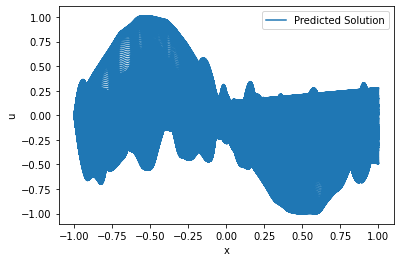

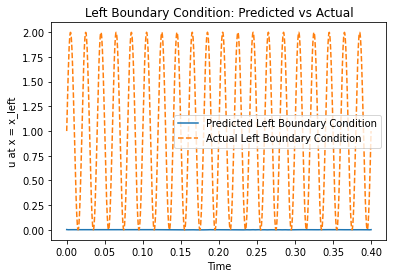

In [3]:


if __name__ == '__main__':

#     # Load your Excel data file
#     data_file = '../40nm_300K.xlsx'  # Ensure this path is correct
#     df = pd.read_excel(data_file, engine='openpyxl', skiprows=3)

#     # Extract the first two columns for X and Y
#     X = df.iloc[:, 2].values[:, None]  # First column for X
#     Y = df.iloc[:, 3].values[:, None]  # Second column for Y

#     # Split the data into 1000 training and 1000 testing points
#     X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=1000, test_size=1000, shuffle=True, random_state=42)


    # Burgers-specific operator
    def burgers_operator(u, t, x, k, sigma_t, sigma_x):
        # Compute the necessary gradients
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]

        # Residuals for the Burgers equation
        residual = u_t + u * u_x - (k / math.pi) * u_xx
        return residual
    
    # Frequency for the boundary condition
    f = 50  # Frequency in Hz
    num_cycles = 20  # Number of cycles in the time domain
    T = num_cycles / f  # Total time to cover 20 cycles

    # Define initial and boundary condition functions
    def initial_condition(x):
        # Initial condition: one cycle of sine wave along x
        return np.sin(-np.pi * x[:, 1:2])

    def left_boundary_condition(t):
        # Left boundary condition: 1 + sin(2 * pi * f * t)
        return 1 + np.sin(2 * np.pi * f * t[:, 0:1])

    # Define the input space
    x_left, x_right = -1, 1
    t_start, t_end = 0, T  # Adjust based on time range

    # Define samplers
    # Define samplers using the existing Sampler class from the model
    ics_sampler = Sampler(
        dim=2,
        coords=np.array([[t_start, x_left], [t_start, x_right]]),
        func=initial_condition
    )
    
    # Left Boundary Condition Sampler (x = x_left, vary t)
    bcs_sampler = [
        Sampler(
            dim=2,
            coords=np.array([[t_start, x_left], [t_end, x_left]]),
            func=lambda t: left_boundary_condition(t)  # Pass time variable here
        )
    ]
    
#     ics_sampler = Sampler(
#         dim=2,
#         coords=np.array([[t_start, x] for x in np.linspace(x_left, x_right, 100)]),  # Sample across x at t = 0
#         func=initial_condition
#     )

#     # Left Boundary Condition Sampler (x = x_left for all t)
#     bcs_sampler = [
#         Sampler(
#             dim=2,
#             coords=np.array([[t, x_left] for t in np.linspace(t_start, t_end, 100)]),  # Sample across t at x = x_left
#             func=left_boundary_condition
#         )
#     ]
    
    # Residual Points Sampler
    def residual_function(coords):
        # Initialize output array
        residual_output = np.zeros((coords.shape[0], 1))

        for i in range(coords.shape[0]):
            t, x = coords[i]

            # Check if the point is in the initial condition
            if t == t_start and (x_left <= x <= x_right):
                residual_output[i] = initial_condition(np.array([[x]]))  # Get initial condition value

            # Check if the point is in the boundary condition
            elif x == x_left and (t_start <= t <= t_end):
                residual_output[i] = left_boundary_condition(np.array([[t]]))  # Get left boundary condition value

        return residual_output

    # Define the residual sampler with the modified function
    res_sampler = Sampler(
        dim=2,
        coords=np.array([[t_start, x_left], [t_end, x_right]]),  # Define your coordinates here
        func=residual_function  # Use the modified residual function
    )

    
    # Define test data (X_star, u_star) for evaluation
    # Create time values from t_start to t_end
    time_values = np.linspace(t_start, t_end, 1000)  # 100 time points
    # Create spatial values
    spatial_values = np.linspace(x_left, x_right, 1000)  # 100 spatial points

    # Create a meshgrid for all combinations of time and space
    X_star = np.array(np.meshgrid(time_values, spatial_values)).T.reshape(-1, 2)  # Shape (N, 2)

    # Initialize u_star as an array of zeros matching the shape of X_star
    u_star = np.zeros((X_star.shape[0], 1))  # Placeholder for exact solution if available



    # Initialize model with Fourier features
    layers = [100, 100, 100, 1]  # Adjust based on architecture
    k = 0.01
    sigma_wt = 10
    sigma_wx = 10

    model = heat1D_ST_FF(
        layers=layers,
        operator=burgers_operator,
        k=k,
        ics_sampler=ics_sampler,
        bcs_sampler=bcs_sampler,
        res_sampler=res_sampler,
        sigma_wt=sigma_wt,
        sigma_wx=sigma_wx,
        X_star=X_star,
        u_star=u_star
    )

    # Train model
    model.train(nIter=10000, batch_size=128)

    # Evaluate and plot results
    u_pred = model.predict_u(X_star)

    plt.plot(X_star[:, 1], u_pred, label='Predicted Solution')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.legend()
    plt.show()
    
    
    
    # Plot the predicted vs actual left boundary condition over time
    # Prepare time values for left boundary condition
    predicted_left_boundary = left_boundary_condition(time_values.reshape(-1, 1))

    # Use the same indices as before to plot the predicted values against the actual boundary condition
    left_boundary_indices = X_star[:, 1] == x_left  # Mask for left boundary points
    predicted_left_boundary_model = u_pred[left_boundary_indices]

    # Plot the left boundary condition over time
    plt.figure()
    plt.plot(time_values, predicted_left_boundary_model, label='Predicted Left Boundary Condition')
    plt.plot(time_values, predicted_left_boundary, label='Actual Left Boundary Condition', linestyle='dashed')
    plt.xlabel('Time')
    plt.ylabel('u at x = x_left')
    plt.legend()
    plt.title("Left Boundary Condition: Predicted vs Actual")
    plt.show()

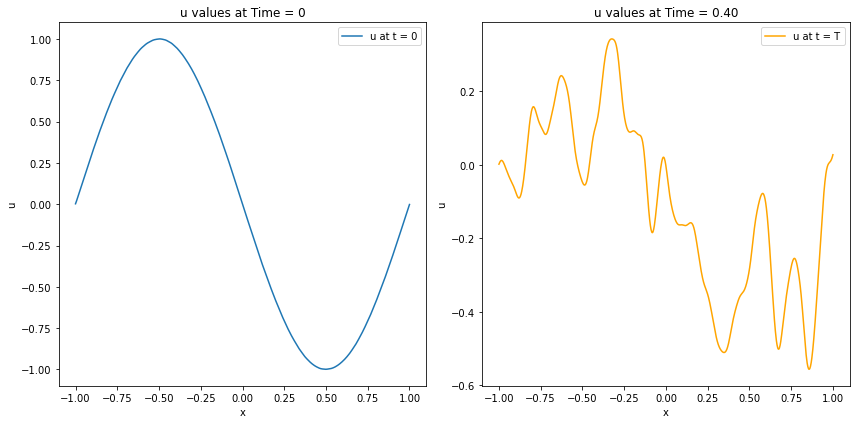

In [4]:
# Extract the u values at the first and last time steps
time_zero_indices = X_star[:, 0] == t_start  # Mask for time = 0
time_end_indices = X_star[:, 0] == t_end  # Mask for time = T

# Values of u at time = 0 and time = T
u_time_zero = u_pred[time_zero_indices]
u_time_end = u_pred[time_end_indices]

# Spatial coordinates at these time steps
x_time_zero = X_star[time_zero_indices, 1]
x_time_end = X_star[time_end_indices, 1]

# Plotting
plt.figure(figsize=(12, 6))

# Plot for time = 0
plt.subplot(1, 2, 1)
plt.plot(x_time_zero, u_time_zero, label='u at t = 0')
plt.title('u values at Time = 0')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()

# Plot for time = T
plt.subplot(1, 2, 2)
plt.plot(x_time_end, u_time_end, label='u at t = T', color='orange')
plt.title(f'u values at Time = {T:.2f}')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()

plt.tight_layout()
plt.show()


In [38]:


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# If you have defined a Sampler class, ensure it's imported here.

if __name__ == '__main__':
    
    # Frequency for the boundary condition
    f = 50  # Frequency in Hz
    num_cycles = 20  # Number of cycles in the time domain
    T = num_cycles / f  # Total time to cover 20 cycles

    # Define initial and boundary condition functions
    def initial_condition(x):
        # Initial condition: one cycle of sine wave along x
        return np.sin(-np.pi * x[:, 1:2])

    def left_boundary_condition(t):
        # Left boundary condition: 1 + sin(2 * pi * f * t)
        return 1 + np.sin(2 * np.pi * f * t[:, 0:1])

    # Define the input space
    x_left, x_right = -1, 1
    t_start, t_end = 0, T  # Adjust based on time range

    # Define samplers for initial and boundary conditions
    ics_sampler = Sampler(
        dim=2,
        coords=np.array([[t_start, x] for x in np.linspace(x_left, x_right, 100)]),  # Sample across x at t = 0
        func=initial_condition
    )
    
    bcs_sampler = Sampler(
        dim=2,
        coords=np.array([[t, x_left] for t in np.linspace(t_start, t_end, 100)]),  # Sample across t at x = x_left
        func=left_boundary_condition
    )

    # Prepare training data from initial and boundary conditions
    initial_x_coords = np.array([[0, x] for x in np.linspace(x_left, x_right, 100)])  # t = 0
    initial_u_values = initial_condition(initial_x_coords)  # Values for initial condition

    boundary_t_coords = np.array([[t, x_left] for t in np.linspace(t_start, t_end, 100)])  # x = x_left
    boundary_u_values = left_boundary_condition(boundary_t_coords)  # Values for boundary condition

    # Combine initial and boundary conditions
    X_train = np.vstack((initial_x_coords, boundary_t_coords))  # Combine coordinates
    u_train = np.vstack((initial_u_values, boundary_u_values))  # Combine values

    # Initialize model with Fourier features
    layers = [100, 100, 100, 1]  # Adjust based on architecture
    k = 0.01
    sigma_wt = 10  # Define the sigma for temporal noise
    sigma_wx = 10  # Define the sigma for spatial noise

    model = heat1D_ST_FF(
        layers=layers,
        k=k,
        sigma_wt=sigma_wt,
        sigma_wx=sigma_wx,
        ics_sampler=ics_sampler,
        bcs_sampler=bcs_sampler,
        X_star=X_train,
        u_star=u_train
    )

    # Train model using only initial and boundary conditions
    model.train(nIter=10000, batch_size=128)

    # Predict on the training data to evaluate the model
    u_pred = model.predict_u(X_train)

    # Plotting the results for the initial condition
    plt.figure(figsize=(10, 6))
    plt.plot(initial_x_coords[:, 1], initial_u_values, 'r-', label='Actual Initial Condition')
    plt.scatter(initial_x_coords[:, 1], u_pred[:100], color='b', label='Predicted Initial Condition', marker='o')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.title('Initial Condition: Actual vs Predicted')
    plt.legend()
    plt.grid()
    plt.show()

    # Plotting the results for the left boundary condition
    plt.figure(figsize=(10, 6))
    plt.plot(boundary_t_coords[:, 0], boundary_u_values, 'r-', label='Actual Left Boundary Condition')
    plt.scatter(boundary_t_coords[:, 0], u_pred[100:], color='b', label='Predicted Left Boundary Condition', marker='o')
    plt.xlabel('Time')
    plt.ylabel('u at x = x_left')
    plt.title('Left Boundary Condition: Actual vs Predicted')
    plt.legend()
    plt.grid()
    plt.show()


TypeError: __init__() missing 2 required positional arguments: 'operator' and 'res_sampler'